Use bollinger band and RSI
To buy:
    1. close crosses above middle bollinger band
    2. RSI > 50
    3. Chaikin money flow > 0
    * Stop loss at lower bollinger
    * Exit when break below lower bollinger, RSI < 50, or CMF < 0
To Sell:
    1. close crosses below middle bollinger
    2. RSI < 50
    3. Chaikin money flow < 0
    * Stop Loss at upper Bollinger
    * Exit when break abover upper bollinger, RSI > 50, or CMF > 0

### Imports

In [1]:
import os
supp_path = 'C:/Users/joepo/Desktop/Back Testing/Supplemental'
import sys
sys.path.insert(1, supp_path)
import backtrader as bt
import datetime
import rando
import strats
import myIndicators as mind
import model_analysis as ma
import matplotlib
%matplotlib inline

***
### Variables

In [2]:
datapath = 'C:/Users/joepo/Desktop/Back Testing/Data/Favs'
datedict = {'d':'%Y-%m-%d'}
iterator = 'd'
force_ticker = None
ticker, startdate, enddate, dateformat, numdays = rando.main(datapath, datedict, iterator, force_ticker)
print("Running backtest from {} to {}; ({} days)".format(startdate, enddate, numdays))
tickerlist = ['ABT'
              ,'ATVI'
              ,'CSCO'
              ,'CVS'
              ,'LOW'
              ,'NKE'
              ,'SBUX'
              ,'T'
              ]
tickerlist = ['ABT', 'ATVI']
startingcash = 10000
sizingperc = 0.025
rsi_thresh = 5
rsi_period = 14
boll_period = 20
boll_dev = 2.0
rsi_sma = True
cmf_period = 14
cmf_thresh = 0.05

Running backtest from 2017-01-07 00:00:00 to 2018-05-13 00:00:00; (1935 days)


***
### Strategy

In [3]:
class BOLL_RSI_CMF(bt.Strategy):
    params = dict(
        sizingPerc = .01
        ,rsiThresh = 0
        ,printLog = True
        ,rsiPeriod = 14
        ,bollPeriod = 20
        ,bollDev = 2.0
        ,rsiType = True
        ,cmfPeriod = 14
        ,cmfThresh = 0
        )

    def __init__(self):
        self.startCash = None
        self.order = {}
        self.stoploss = {}
        self.aboveMid = {}
        self.belowMid = {}
        self.RSIup = {}
        self.RSIdown = {}
        self.CMFup = {}
        self.CMFdown = {}
        self.ls = {}
        self.highStop = {}
        self.lowStop = {}
        self.inds = {}
        for i, d in enumerate(self.datas):
            self.order[d] = None
            self.stoploss[d] = None
            self.aboveMid[d] = None
            self.belowMid[d] = None
            self.RSIup[d] = None
            self.RSIdown[d] = None
            self.CMFup[d] = None
            self.CMFdown[d] = None
            self.ls[d] = 0
            self.highStop[d] = 0.0
            self.lowStop[d] = 0.0
            self.inds[d] = {}
            if self.p.rsiType:
                self.inds[d]['RSI'] = bt.ind.RSI_SMA(d.close, period = self.p.rsiPeriod)
            else:
                self.inds[d]['RSI'] = bt.ind.RSI_EMA(d.close, period = self.p.rsiPeriod)
            self.inds[d]['Bands'] = bt.ind.BBands(d.close, period = self.p.bollPeriod, devfactor = self.p.bollDev)
            self.inds[d]['CMF'] = mind.ChaikinMoneyFlow(d, period = self.p.cmfPeriod)
            self.inds[d]['Boll Up'] = bt.ind.CrossUp(d.close, self.inds[d]['Bands'].lines.mid, plot=False)
            self.inds[d]['Boll Down'] = bt.ind.CrossDown(d.close, self.inds[d]['Bands'].lines.mid, plot=False)
            self.inds[d]['RSI Buy'] = bt.ind.CrossUp(self.inds[d]['RSI'].lines.rsi, 50 + self.p.rsiThresh, plot=False)
            self.inds[d]['RSI Sell'] = bt.ind.CrossDown(self.inds[d]['RSI'].lines.rsi, 50 - self.p.rsiThresh, plot=False)
            self.inds[d]['CMF Buy'] = bt.ind.CrossUp(self.inds[d]['CMF'].lines.mfi, 0 + self.p.cmfThresh, plot=False)
            self.inds[d]['CMF Sell'] = bt.ind.CrossDown(self.inds[d]['CMF'].lines.mfi, 0 - self.p.cmfThresh, plot=False)
            self.inds[d]['Bottom Cross'] = bt.ind.CrossDown(d.close, self.inds[d]['Bands'].lines.bot, plot=False)
            self.inds[d]['Top Cross'] = bt.ind.CrossUp(d.close, self.inds[d]['Bands'].lines.top, plot=False)
            self.inds[d]['RSI Close Long'] = bt.ind.CrossDown(self.inds[d]['RSI'].lines.rsi, 50, plot=False)
            self.inds[d]['RSI Close Short'] = bt.ind.CrossUp(self.inds[d]['RSI'].lines.rsi, 50, plot=False)
            self.inds[d]['CMF Close Long'] = bt.ind.CrossDown(self.inds[d]['CMF'].lines.mfi, 0, plot=False)
            self.inds[d]['CMF Close Short'] = bt.ind.CrossUp(self.inds[d]['CMF'].lines.mfi, 0, plot=False)

    def start(self):
        self.startCash = self.broker.getvalue()
    
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        if order.status in [order.Completed]:
            d = order.data
            if order.isbuy():
                bs = "Bought"
                self.ls[d] = 1
            else:
                bs = "Sold"
                self.ls[d] = -1
            self.log("{} {} shares of {} for ${:.2f}".format(
                bs
                ,order.executed.size
                ,d._name
                ,order.executed.price))
        elif order.status in [order.Canceled]:
            self.log('Order Canceled for {}'.format(order.data._name))
        elif order.status in [order.Margin, order.Rejected]:
            self.log('Order rejected or margin issue')   
    
    def notify_trade(self, trade):
        d = trade.data
        if not trade.isclosed:
            return
        self.log("P&L:  ${:.2f}".format(trade.pnlcomm))
        self.stoploss[d] = None
        self.resetBools(d)

    def log(self, txt):
        if self.p.printLog:
            date = self.datas[0].datetime.date(0)
            print("{}: {}".format(date, txt))

    def sizingCalc(self, capital, price):
        available = float(capital) * self.p.sizingPerc
        shares = round(available/price)
        return shares

    def resetBools(self, t):
        self.belowMid[t] = False
        self.aboveMid[t] = False
        self.RSIup[t] = False
        self.RSIdown[t] = False
        self.CMFup[t] = False
        self.CMFdown[t] = False

    def next(self):
        for i, d in enumerate(self.datas):
            if self.getposition(d).size == 0:
                ##Check entry indicators
                if self.inds[d]['Boll Up'][0]:
                    #self.log("{} closed above middle band".format(d._name))
                    self.belowMid[d] = False
                    self.aboveMid[d] = True
                elif self.inds[d]['Boll Down'][0]:
                    #self.log("{} closed below middle band".format(d._name))
                    self.belowMid[d] = True
                    self.aboveMid[d] = False
                #else:
                    #self.log("{} did not cross Boll".format(d._name))
                if self.inds[d]['RSI Buy'][0]:
                    self.RSIup[d] = True
                    self.RSIdown[d] = False
                elif self.inds[d]['RSI Sell'][0]:
                    self.RSIup[d] = False
                    self.RSIdown[d] = True
                #else:
                    #self.log("{} did not cross RSI".format(d._name))
                if self.inds[d]['CMF Buy'][0]:
                    self.CMFup[d] = True
                    self.CMFdown[d] = False
                elif self.inds[d]['CMF Sell'][0]:
                    self.CMFup[d] = False
                    self.CMFdown[d] = True
                #else:
                    #self.log("{} did not cross CMF".format(d._name))
                ##if all indicators, buy/sell
                if self.aboveMid[d] and self.RSIup[d] and self.CMFup[d]:
                    numShares = self.sizingCalc(self.broker.getvalue(), d.close[0])
                    self.order[d] = self.buy(data=d, size=numShares)
                    self.log("Buy {} shares of {}".format(numShares, d._name))
                    self.lowStop[d] = self.inds[d]['Bands'].lines.bot[0]
                elif self.belowMid[d] and self.RSIdown[d] and self.CMFdown[d]:
                    numShares = self.sizingCalc(self.broker.getvalue(), d.close[0])
                    self.order[d] = self.sell(data=d, size=numShares)
                    self.log("Sell {} shares of {}".format(numShares, d._name))
                    self.highStop[d] = self.inds[d]['Bands'].lines.top[0]
            ##Exits
            else:
                if self.stoploss[d] is None:
                    if self.ls[d] > 0:
                        self.stoploss[d] = self.close(data=d
                                                      ,exectype=bt.Order.Stop
                                                      ,price = self.lowStop[d]
                                                      )
                        self.log("Sell stop created at ${:.2f} for {}".format(
                            self.lowStop[d], d._name))
                    else:
                        self.stoploss[d] = self.close(data=d
                                                      ,exectype=bt.Order.Stop
                                                      ,price = self.highStop[d]
                                                      )
                        self.log("Buy stop created at ${:.2f} for {}".format(
                            self.highStop[d], d._name))
                if self.ls[d] > 0 and self.inds[d]['Bottom Cross'][0]:
                    self.order[d] = self.close(data=d)
                    self.cancel(self.stoploss[d])
                    self.log("Lower band crossed for {}, close position".format(d._name))
                elif self.ls[d] > 0 and self.inds[d]['RSI Close Long'][0]:
                    self.order[d] = self.close(data=d)
                    self.cancel(self.stoploss[d])
                    self.log("RSI broke below for {}, close position".format(d._name))
                elif self.ls[d] > 0 and self.inds[d]['CMF Close Long'][0]:
                    self.order[d] = self.close(data=d)
                    self.cancel(self.stoploss[d])
                    self.log("CMF brok below for {}, close position".format(d._name))
                elif self.ls[d] < 0 and self.inds[d]['Top Cross'][0]:
                    self.order[d] = self.close(data=d)
                    self.cancel(self.stoploss[d])
                    self.log("Upper band crossed for {}, close position".format(d._name))
                elif self.ls[d] < 0 and self.inds[d]['RSI Close Short'][0]:
                    self.order[d] = self.close(data=d)
                    self.cancel(self.stoploss[d])
                    self.log("RSI broke above for {}, close position".format(d._name))
                elif self.ls[d] < 0 and self.inds[d]['CMF Close Short'][0]:
                    self.order[d] = self.close(data=d)
                    self.cancel(self.stoploss[d])
                    self.log("CMF broke above for {}, close position".format(d._name))
        self.log("\n")

    def stop(self):
        pnl = self.broker.getvalue() - self.startCash
        print("\n\n ------- Final Analysis ------- ")
        print("Ending Value: ${:.2f}\nP&L:  ${:.2f}\n".format(self.broker.getvalue(), pnl))

***
### Cerebro

In [4]:
cerebro = bt.Cerebro()
for t in tickerlist:
    data = bt.feeds.GenericCSVData(dataname = os.path.join(datapath, t + '.csv')
                                   ,fromdate = startdate
                                   ,todate = enddate
                                   ,nullvalue = 0.0
                                   ,dtformat = dateformat
                                   ,datetime = 0
                                   ,high = 2
                                   ,low = 3
                                   ,open = 1
                                   ,close = 4
                                   ,volume = 6
                                   ,openinterest = -1 #no open interest column
                                   )
    cerebro.adddata(data, name=t)
cerebro.broker.set_cash(startingcash)
## add strategy
cerebro.addstrategy(BOLL_RSI_CMF
                    ,sizingPerc = sizingperc
                    ,rsiThresh = rsi_thresh
                    ,rsiPeriod = rsi_period
                    ,bollPeriod = boll_period
                    ,bollDev = boll_dev
                    ,cmfPeriod = cmf_period)

0

***
### Results

2017-02-07: 

2017-02-08: 

2017-02-09: 

2017-02-10: 

2017-02-13: 

2017-02-14: 

2017-02-15: 

2017-02-16: 

2017-02-17: 

2017-02-21: 

2017-02-22: 

2017-02-23: 

2017-02-24: 

2017-02-27: 

2017-02-28: 

2017-03-01: 

2017-03-02: 

2017-03-03: 

2017-03-06: Buy 5 shares of ATVI
2017-03-06: 

2017-03-07: Bought 5 shares of ATVI for $47.73
2017-03-07: Sell stop created at $39.53 for ATVI
2017-03-07: 

2017-03-08: 

2017-03-09: 

2017-03-10: 

2017-03-13: 

2017-03-14: 

2017-03-15: 

2017-03-16: 

2017-03-17: 

2017-03-20: 

2017-03-21: 

2017-03-22: 

2017-03-23: 

2017-03-24: 

2017-03-27: 

2017-03-28: 

2017-03-29: 

2017-03-30: 

2017-03-31: 

2017-04-03: 

2017-04-04: RSI broke below for ATVI, close position
2017-04-04: 

2017-04-05: Order Canceled for ATVI
2017-04-05: Sold -5 shares of ATVI for $49.19
2017-04-05: P&L:  $7.30
2017-04-05: 

2017-04-06: Sell 6 shares of ABT
2017-04-06: 

2017-04-07: Sold -6 shares of ABT for $43.62
2017-04-07: Buy stop created at $45.72 for ABT

2018-03-20: 

2018-03-21: 

2018-03-22: Sell 4 shares of ATVI
2018-03-22: 

2018-03-23: Sold -4 shares of ATVI for $69.86
2018-03-23: RSI broke below for ABT, close position
2018-03-23: Buy stop created at $77.81 for ATVI
2018-03-23: 

2018-03-26: Order Canceled for ABT
2018-03-26: Sold -4 shares of ABT for $60.28
2018-03-26: P&L:  $-1.88
2018-03-26: 

2018-03-27: 

2018-03-28: 

2018-03-29: 

2018-04-02: 

2018-04-03: 

2018-04-04: 

2018-04-05: 

2018-04-06: 

2018-04-09: 

2018-04-10: CMF broke above for ATVI, close position
2018-04-10: 

2018-04-11: Order Canceled for ATVI
2018-04-11: Bought 4 shares of ATVI for $65.80
2018-04-11: P&L:  $16.24
2018-04-11: 

2018-04-12: 

2018-04-13: 

2018-04-16: 

2018-04-17: 

2018-04-18: 

2018-04-19: 

2018-04-20: 

2018-04-23: 

2018-04-24: 

2018-04-25: Sell 4 shares of ATVI
2018-04-25: 

2018-04-26: Sold -4 shares of ATVI for $65.26
2018-04-26: Buy 4 shares of ABT
2018-04-26: Buy stop created at $68.47 for ATVI
2018-04-26: RSI broke above fo

<IPython.core.display.Javascript object>


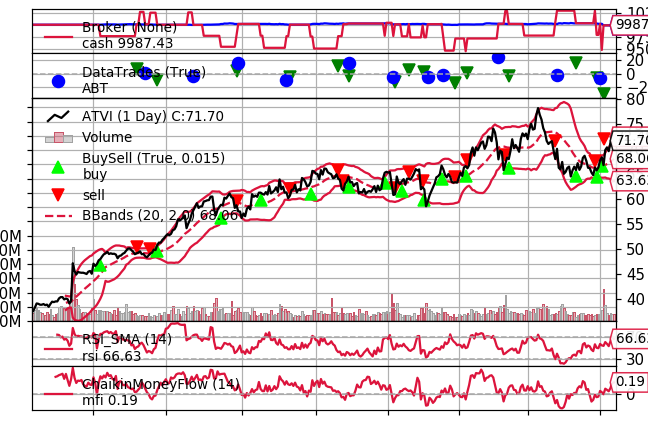

In [5]:
#add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
cerebro.addanalyzer(bt.analyzers.SQN, _name='sqn')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')
cerebro.addanalyzer(bt.analyzers.Returns, _name='annRets')
#run backtest
test = cerebro.run()
analysis = test[0]
#get analyzers
sharpe = analysis.analyzers.sharpe.get_analysis()
sqn = analysis.analyzers.sqn.get_analysis()
rets = analysis.analyzers.annRets.get_analysis()
trade = analysis.analyzers.trades.get_analysis()
#print analysis
print(ma.main_analysis(sharpe, sqn, rets))
print(ma.trade_analysis(trade))
#plot
for i in range(len(test[0].datas)):
    for j, d in enumerate(test[0].datas):
        d.plotinfo.plot = i == j
        
    cerebro.plot()